In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pynba import seasons_on_file, use_blackontrans_style, halfgames_from_file


use_blackontrans_style()

In [3]:
seasons = seasons_on_file()

halfgames = pd.concat([
    halfgames_from_file(league, year, season_type)
    for league, year, season_type
    in zip(seasons["league"], seasons["year"], seasons["season_type"])
    if ((league == "nba") & (season_type == "Regular Season"))
], ignore_index=True)

In [3]:
offense_pace_data = halfgames.groupby(by=['off_team_id', 'year'], as_index=False).agg({'duration': 'sum', 'possession_num': 'sum'})
offense_pace_data['pace'] = offense_pace_data['duration'] / offense_pace_data['possession_num']
defense_pace_data = halfgames.groupby(by=['def_team_id', 'year'], as_index=False).agg({'duration': 'sum', 'possession_num': 'sum'})
defense_pace_data['pace'] = defense_pace_data['duration'] / defense_pace_data['possession_num']

pace_data = offense_pace_data.merge(defense_pace_data, left_on=['off_team_id' ,'year'], right_on=['def_team_id', 'year'], suffixes=('_off', '_def'))
pace_data = pace_data.rename(columns={'off_team_id': 'team_id'}).drop(columns='def_team_id')
pace_data['extra_possessions'] = pace_data['possession_num_off'] - pace_data['possession_num_def']

rows = []
for row in pace_data.itertuples():
    out = {}
    team_id = row.team_id
    year = row.year
    filt = (pace_data['team_id'] == team_id) & (pace_data['year'] == (year + 1))
    if not filt.any():
        continue
    out['team_id'] = team_id
    out['year'] = year
    out['x'] = row.extra_possessions
    out['y'] = pace_data.loc[filt, 'extra_possessions'].iloc[0]
    rows.append(out)

year_to_year_pace_data = pd.DataFrame(rows)

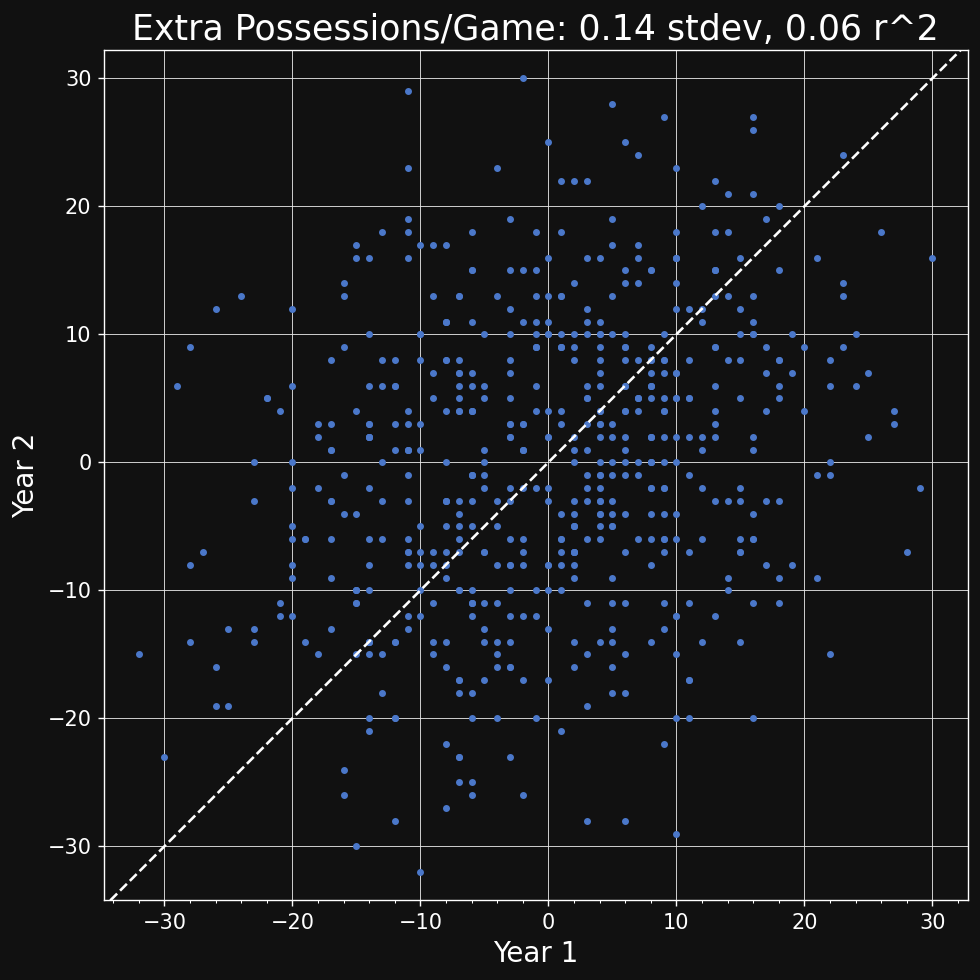

In [10]:
r2 = np.corrcoef(year_to_year_pace_data['x'], year_to_year_pace_data['y'])[0][1] ** 2
std = pace_data['extra_possessions'].std() / 82

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(year_to_year_pace_data['x'], year_to_year_pace_data['y'], '.', alpha=1)
ax.axline((1, 1), slope=1, ls='--', c='w')
ax.set_xlabel('Year 1')
ax.set_ylabel('Year 2')
ax.axis('equal')
ax.set_title(f'Extra Possessions/Game: {std:.2f} stdev, {r2:.2f} r^2');

In [34]:
# Least squares regression for shot rate estimate
y = halfgames['shots_per_opp']
X = np.hstack((np.ones((halfgames.shape[0], 1)), halfgames[['turnover_rate', 'ft_attempt_rate', 'off_reb_rate']].values))
k, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
halfgames["shots_per_opp_est"] = X.dot(k)
k_1, k_to, k_fta, k_reb = k
k

array([ 0.96887837, -0.88843323, -0.42600154,  0.1149958 ])

In [37]:
halfgames["foul_rate"] = (halfgames["possession_num"] + halfgames["off_rebs"] - halfgames["turnovers"] - halfgames["threes_attempted"] - halfgames["twos_attempted"]) / (halfgames["possession_num"] + halfgames["off_rebs"])

In [56]:
# Least squares regression for shot rate estimate
y = halfgames['foul_rate']
X = np.hstack((np.ones((halfgames.shape[0], 1)), halfgames[['ft_attempt_rate', 'three_make_rate', 'two_make_rate']].values))
k, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
halfgames["shots_per_opp_est"] = X.dot(k)
k_1, k_fta, k_3pt, k_2pt = k
k

array([-0.01342904,  0.41735738,  0.01590615,  0.02131211])

,k_1,k_fta,k_3pt,k_2pt
year,,,,
2001,-0.012063,0.415044,0.011600,0.028273
2002,-0.014923,0.412904,0.014700,0.030272
2003,-0.013780,0.423031,0.014306,0.023688
2004,-0.017680,0.414337,0.015914,0.035730
2005,-0.021219,0.420897,0.016430,0.036225
2006,-0.014738,0.413804,0.015566,0.027275
2007,-0.013730,0.417807,0.014903,0.021507
2008,-0.016613,0.414391,0.014366,0.030191
2009,-0.013619,0.417501,0.012136,0.023536


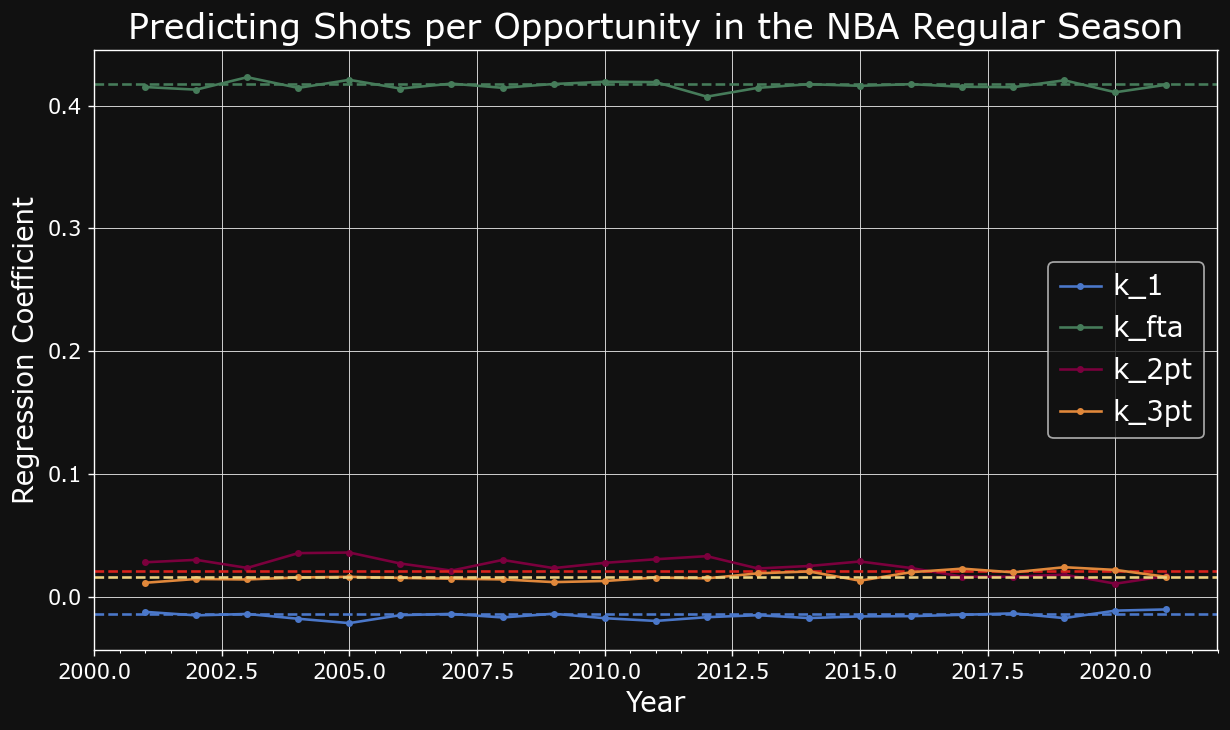

In [58]:
rows = []

for year, sub_hg in halfgames.groupby("year"):
    y = sub_hg['foul_rate'].values
    X = np.hstack((np.ones((sub_hg.shape[0], 1)), sub_hg[['ft_attempt_rate', 'three_make_rate', 'two_make_rate']].values))
    k, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
    row = {}
    row["year"] = year
    row['k_1'], row['k_fta'], row["k_3pt"], row["k_2pt"] = k
    rows.append(row)

reg_data = pd.DataFrame(rows)
reg_data.index = reg_data.pop("year")


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(reg_data["k_1"], ".-", label="k_1")
ax.axhline(k_1, ls="--", color="C0")
ax.plot(reg_data["k_fta"], ".-", label="k_fta")
ax.axhline(k_fta, ls="--", color="C1")
ax.plot(reg_data["k_2pt"], ".-", label="k_2pt")
ax.axhline(k_2pt, ls="--", color="C4")
ax.plot(reg_data["k_3pt"], ".-", label="k_3pt")
ax.axhline(k_3pt, ls="--", color="C5")
ax.set_xlabel("Year")
ax.set_ylabel("Regression Coefficient")
ax.legend()
ax.set_title("Predicting Shots per Opportunity in the NBA Regular Season")

reg_data.loc["mean", :] = (k_1, k_fta, k_3pt, k_2pt)
reg_data

,k_1,k_to,k_fta,k_reb
year,,,,
2001,0.961840,-0.886264,-0.425643,0.128965
2002,0.962626,-0.881034,-0.421761,0.123524
2003,0.967207,-0.875526,-0.432930,0.114385
2004,0.957850,-0.868728,-0.421268,0.132392
2005,0.962483,-0.870470,-0.430022,0.127803
2006,0.964162,-0.882174,-0.423809,0.123391
2007,0.963746,-0.883558,-0.425454,0.129462
2008,0.966216,-0.894730,-0.422134,0.123772
2009,0.969027,-0.878503,-0.428659,0.111051


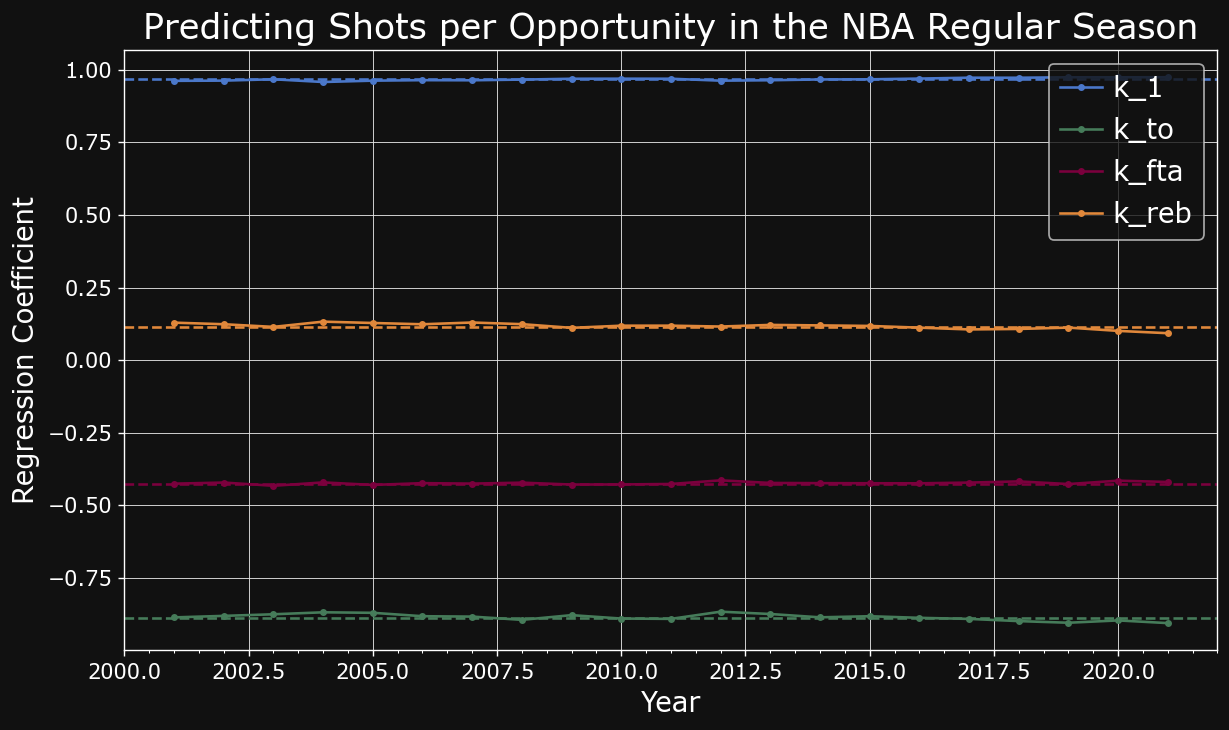

In [31]:
rows = []

for year, sub_hg in halfgames.groupby("year"):
    y = sub_hg['shots_per_opp'].values
    X = np.hstack((np.ones((sub_hg.shape[0], 1)), sub_hg[['turnover_rate', 'ft_attempt_rate', 'off_reb_rate']].values))
    k, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
    row = {}
    row["year"] = year
    row['k_1'], row['k_to'], row['k_fta'], row['k_reb'] = k
    rows.append(row)

reg_data = pd.DataFrame(rows)
reg_data.index = reg_data.pop("year")


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(reg_data["k_1"], ".-", label="k_1")
ax.axhline(k_1, ls="--", color="C0")
ax.plot(reg_data["k_to"], ".-", label="k_to")
ax.axhline(k_to, ls="--", color="C1")
ax.plot(reg_data["k_fta"], ".-", label="k_fta")
ax.axhline(k_fta, ls="--", color="C2")
ax.plot(reg_data["k_reb"], ".-", label="k_reb")
ax.axhline(k_reb, ls="--", color="C3")
# ax.plot(reg_data["k_2pt%"], ".-", label="k_2pt%")
# ax.axhline(k_2pt, ls="--", color="C4")
# ax.plot(reg_data["k_3pt%"], ".-", label="k_3pt%")
# ax.axhline(k_3pt, ls="--", color="C5")
# ax.plot(reg_data["k_3pta"], ".-", label="k_3pta")
# ax.axhline(k_3pta, ls="--", color="C6")
ax.set_xlabel("Year")
ax.set_ylabel("Regression Coefficient")
ax.legend()
ax.set_title("Predicting Shots per Opportunity in the NBA Regular Season")

reg_data.loc["mean", :] = (k_1, k_to, k_fta, k_reb)
reg_data

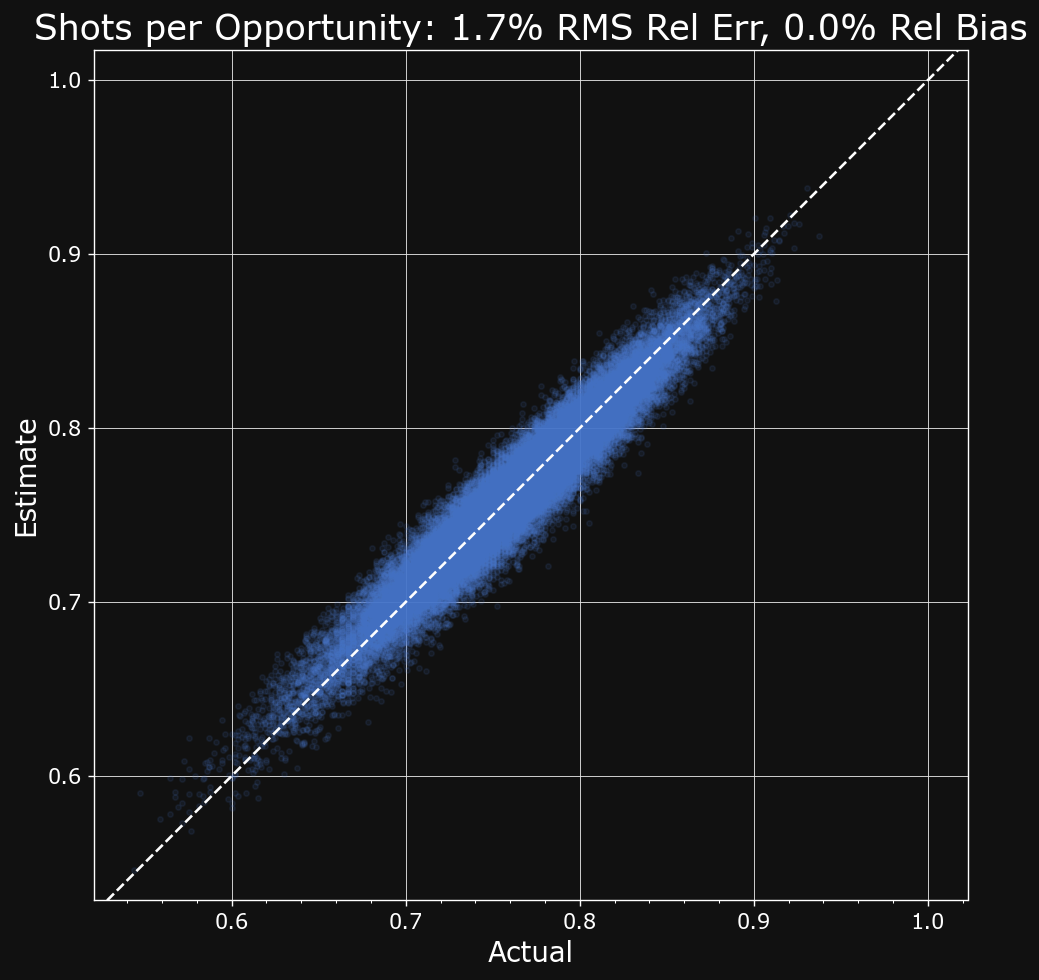

In [35]:
rel_error = (halfgames['shots_per_opp_est'] - halfgames['shots_per_opp']) / halfgames['shots_per_opp']
rms_error = np.sqrt(np.mean(rel_error ** 2))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(halfgames['shots_per_opp'], halfgames['shots_per_opp_est'], '.', alpha=0.1)
ax.axline((1, 1), slope=1, ls='--', c='w')
ax.set_xlabel('Actual')
ax.set_ylabel('Estimate')
ax.axis('equal')
ax.set_title(f'Shots per Opportunity: {rms_error * 1e2:.1f}% RMS Rel Err, {rel_error.mean() * 1e2:.1f}% Rel Bias');

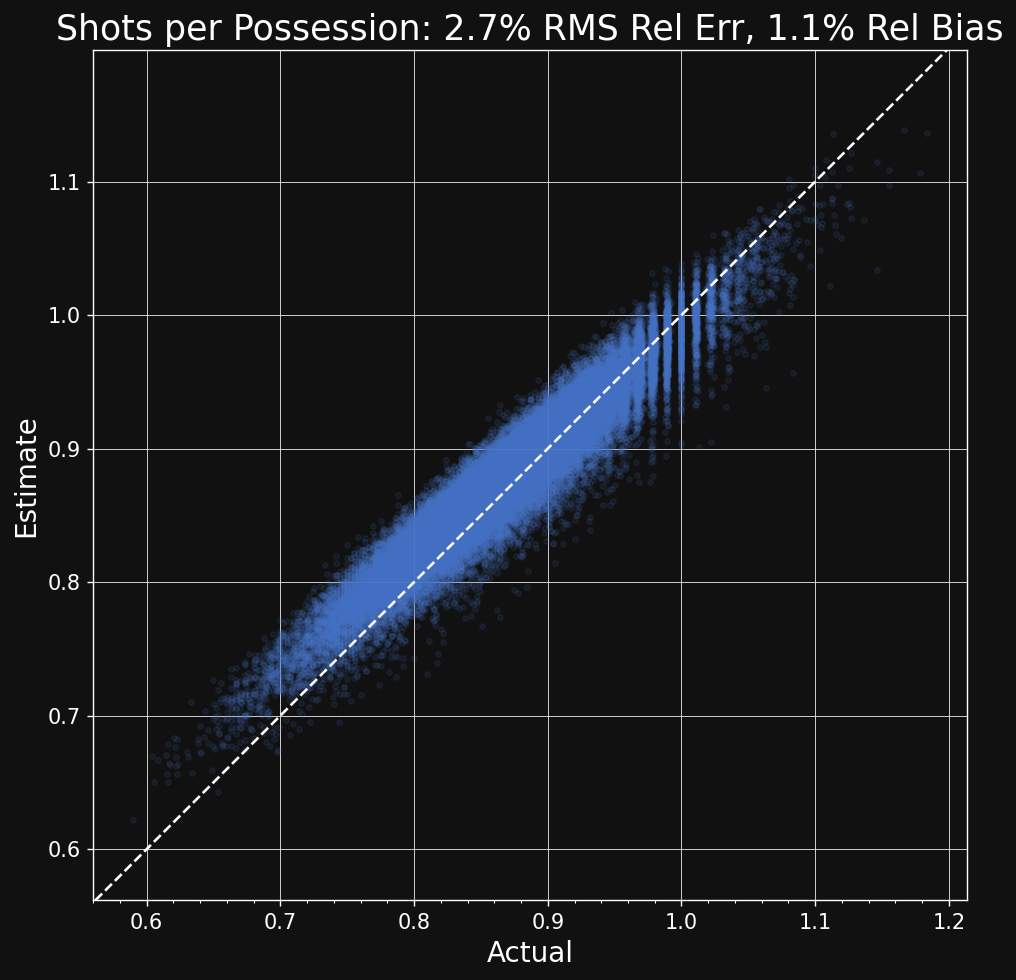

In [8]:
rel_error = (halfgames['shots_per_poss_est'] - halfgames['shots_per_poss']) / halfgames['shots_per_poss']
rms_error = np.sqrt(np.mean(rel_error ** 2))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(halfgames['shots_per_poss'], halfgames['shots_per_poss_est'], '.', alpha=0.1)
ax.axline((1, 1), slope=1, ls='--', c='w')
ax.set_xlabel('Actual')
ax.set_ylabel('Estimate')
ax.axis('equal')
ax.set_title(f'Shots per Possession: {rms_error * 1e2:.1f}% RMS Rel Err, {rel_error.mean() * 1e2:.1f}% Rel Bias');

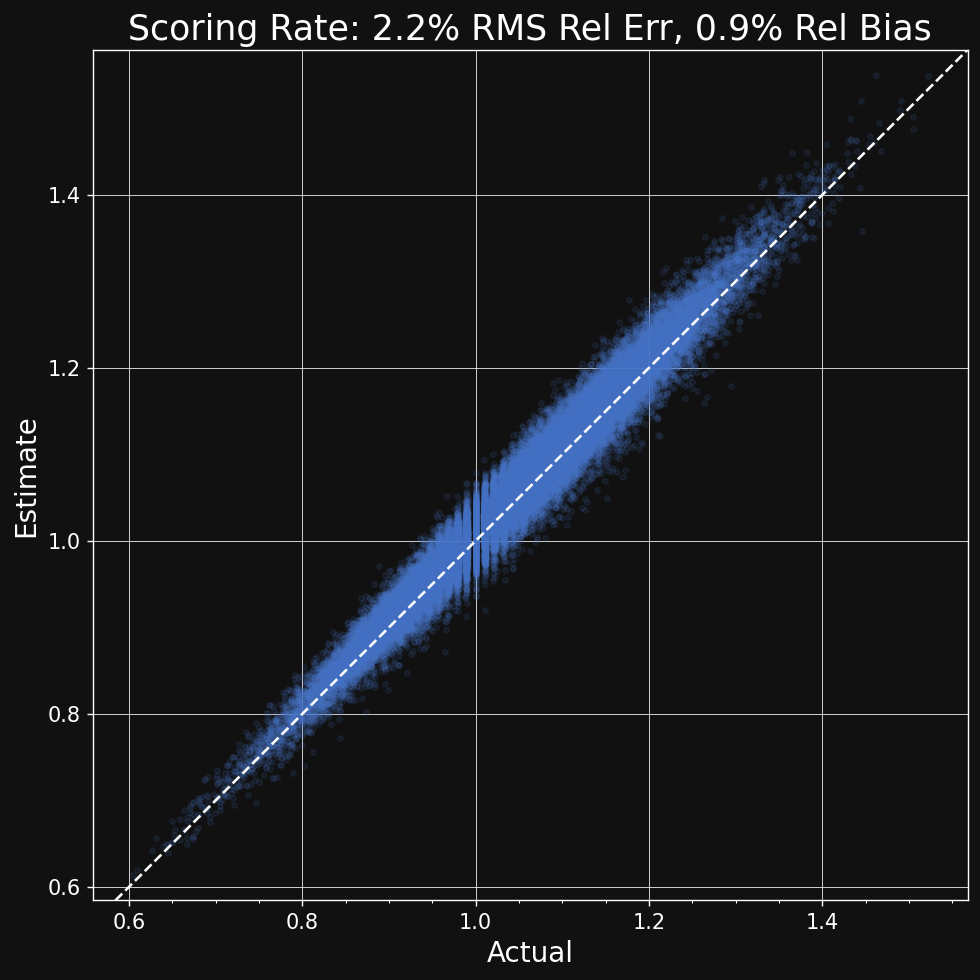

In [9]:
rel_error = (halfgames['scoring_rate_est'] - halfgames['scoring_rate']) / halfgames['scoring_rate']
rms_error = np.sqrt(np.mean(rel_error ** 2))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(halfgames['scoring_rate'], halfgames['scoring_rate_est'], '.', alpha=0.1)
ax.axline((1, 1), slope=1, ls='--', c='w')
ax.set_xlabel('Actual')
ax.set_ylabel('Estimate')
ax.axis('equal')
ax.set_title(f'Scoring Rate: {rms_error * 1e2:.1f}% RMS Rel Err, {rel_error.mean() * 1e2:.1f}% Rel Bias');